# SAE implementations

In [51]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=784, hidden_size=64, k_top=20):
        super(SparseAutoencoder, self).__init__()
        self.training = True
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.k_top = k_top
        self.name = "Default Sparse Autoencoder"

        # Encoder maps input to hidden representation
        self.encoder = nn.Linear(input_size, hidden_size)

        # Decoder maps hidden representation back to input space
        self.decoder = nn.Linear(hidden_size, input_size)

    def _topk_mask(self, activations: torch.Tensor) -> torch.Tensor:
        # activations: (batch, hidden)
        k = max(0, min(self.k_top, activations.size(1)))
        _, idx = torch.topk(activations, k, dim=1)
        mask = torch.zeros_like(activations)
        mask.scatter_(1, idx, 1.0)
        return mask

    def forward(self, x):
        pre_activations = self.encoder(x)
        pre_activations = F.relu(pre_activations)
        mask = self._topk_mask(pre_activations)
        h = pre_activations * mask
        x_hat = self.decoder(h)
        return h, x_hat


    def compute_loss(self, x, h, x_hat):
        # We compute sum of squares and normalize by input dimension 'd'
        recon_loss = torch.sum((x - x_hat) ** 2) / (x.size(0))

        return recon_loss

In [52]:

class SparseAutoencoderInit(SparseAutoencoder):
    def __init__(self, input_size=784, hidden_size=64, k_top=20):
        super(SparseAutoencoderInit, self).__init__(input_size, hidden_size, k_top)

        self.name = "Sparse Autoencoder with just weight initialization"
        # Initialize encoder weights first with random directions
        nn.init.kaiming_uniform_(self.encoder.weight, a=math.sqrt(5))
        # Initialize the decoder to be the transpose of the encoder weights
        with torch.no_grad():
            self.decoder.weight.copy_(self.encoder.weight.t())


In [53]:

class SparseAutoencoderJumpReLU(SparseAutoencoder):
    def __init__(self, input_size=784, hidden_size=64, k_top=20, jump_value=0.1):
        super(SparseAutoencoderJumpReLU, self).__init__(input_size, hidden_size, k_top)
        self.name = "Sparse Autoencoder with Jump ReLU"
        self.jump_value = jump_value

    def forward(self, x: torch.Tensor):
        h_raw = self.encoder(x)
        mask = self._topk_mask(h_raw)
        h = h_raw * mask
        # Apply JumpReLU
        h = torch.where(h > self.jump_value, h, torch.zeros_like(h))
        x_hat = self.decoder(h)
        return h, x_hat

In [54]:

class SparseAutoencoderInitJumpReLU(SparseAutoencoder):
    def __init__(self, input_size=784, hidden_size=64, k_top=20, jump_value=0.1):
        super(SparseAutoencoderInitJumpReLU, self).__init__(input_size, hidden_size, k_top)
        self.name = "Sparse Autoencoder with Initialization and Jump ReLU"
        self.jump_value = jump_value

        # Initialize encoder weights first with random directions
        nn.init.kaiming_uniform_(self.encoder.weight, a=math.sqrt(5))
        # Initialize the decoder to be the transpose of the encoder weights
        with torch.no_grad():
            self.decoder.weight.copy_(self.encoder.weight.t())


    def forward(self, x: torch.Tensor):
        h_raw = self.encoder(x)
        mask = self._topk_mask(h_raw)
        h = h_raw * mask
        # Apply JumpReLU
        h = torch.where(h > self.jump_value, h, torch.zeros_like(h))
        x_hat = self.decoder(h)
        return h, x_hat

In [55]:
class SparseAutoencoderAdaptiveBatchTopK(SparseAutoencoder):
    def __init__(self, input_size=784, hidden_size=64, k_top=20):
        super(SparseAutoencoderAdaptiveBatchTopK, self).__init__(input_size, hidden_size, k_top)
        self.name = "Sparse Autoencoder with Adaptive Batch TopK"

    def _adaptive_batch_topk_mask(self, activations: torch.Tensor) -> torch.Tensor:
        """
        Select features based on global batch statistics and per-sample TopK
        """
        batch_size, hidden_size = activations.shape
        k = max(0, min(self.k_top * batch_size, hidden_size * batch_size))
        
        # Method 1: Global threshold approach
        # Find the k-th largest activation value across the entire batch
        flattened = activations.view(-1)  # (batch_size * hidden_size,)
        kth_largest = torch.kthvalue(flattened, len(flattened) - k * batch_size + 1).values
        
        # Create mask: keep activations above this threshold
        mask = (activations >= kth_largest).float()
        
        return mask

    def forward(self, x):
        pre_activations = self.encoder(x)
        pre_activations = F.relu(pre_activations)
        mask = self._adaptive_batch_topk_mask(pre_activations)
        h = pre_activations * mask
        x_hat = self.decoder(h)
        return h, x_hat

Implementing auxiliary loss SAE

In [56]:

class SparseAutoencoderAuxLoss(SparseAutoencoder):
    def __init__(self, input_size, hidden_size, k_top, k_aux, k_aux_param, dead_feature_threshold):
        super(SparseAutoencoderAuxLoss, self).__init__(input_size, hidden_size, k_top)
        self.name = "Sparse Autoencoder with Auxiliary Loss"
        # k_aux is typically 2*k or more to revive dead features
        self.k_aux = k_aux if k_aux is not None else 2 * k_top
        self.k_aux_param = k_aux_param
        # Track dead features: count steps since each feature was last active
        self.register_buffer('steps_since_active', torch.zeros(hidden_size))
        self.dead_feature_threshold = dead_feature_threshold

    # Function to track which features are dead
    def _update_dead_features(self, h: torch.Tensor):
        # Feature is active if ANY sample in batch activates it
        active_mask = (h.abs() > 1e-8).any(dim=0)

        # Increment counter for inactive features, reset for active ones
        self.steps_since_active += 1
        self.steps_since_active[active_mask] = 0

    def _get_dead_feature_mask(self) -> torch.Tensor:
        """Return boolean mask of dead features"""
        return self.steps_since_active > self.dead_feature_threshold

    def forward(self, x: torch.Tensor):
        h_raw = self.encoder(x)
        mask = self._topk_mask(h_raw)
        h = h_raw * mask
        x_hat = self.decoder(h)

        # Track dead features during training
        if self.training:
            self._update_dead_features(h)

        return h, x_hat

    def compute_loss(self, x, h, x_hat):
        # Main reconstruction loss
        recon_error = torch.sum((x - x_hat) ** 2)
        recon_loss = recon_error / self.input_size

        # Auxiliary loss using dead features only
        aux_loss = torch.tensor(0.0, device=x.device)

        if self.training:
            dead_mask = self._get_dead_feature_mask()  # (hidden_size,)
            n_dead = dead_mask.sum().item()

            if n_dead > 0:
                # Compute reconstruction error: e = x - x_hat
                recon_error_vec = x - x_hat  # (batch, input_size)

                # Get raw activations again (before TopK masking)
                with torch.no_grad():
                    h_raw = self.encoder(x)

                # Select only dead features
                h_dead = h_raw * dead_mask.float().unsqueeze(0)  # (batch, hidden_size)

                # Select top-k_aux dead features
                k_aux_features = min(self.k_aux, n_dead)
                _, idx_aux = torch.topk(h_dead, k_aux_features, dim=1)
                mask_aux = torch.zeros_like(h_dead)
                mask_aux.scatter_(1, idx_aux, 1.0)

                # Sparse activations using only dead features
                z_aux = h_raw * mask_aux  # (batch, hidden_size)

                # Reconstruct error using dead features
                e_hat = self.decoder(z_aux)  # (batch, input_size)

                # Auxiliary loss: ||e - e_hat||^2
                aux_loss = torch.sum((recon_error_vec - e_hat) ** 2) / self.input_size

        # Total loss
        total_loss = recon_loss + self.k_aux_param * aux_loss

        return total_loss, recon_loss, aux_loss

Complete with relu, init and aux loss implementation.

In [57]:

class SparseAutoencoderComplete(SparseAutoencoder):
    def __init__(self, input_size, hidden_size, k_top, dead_feature_threshold, jump_value):
        super(SparseAutoencoderComplete, self).__init__(input_size, hidden_size, k_top)
        self.name = "Sparse Autoencoder with weight init., JumpReLU and Auxiliary Loss"
        self.jump_value = jump_value

        # k_aux is typically 2*k or more to revive dead features
        self.k_aux = k_aux if k_aux is not None else 2 * k_top
        self.k_aux_param = k_aux_param
        # Track dead features: count steps since each feature was last active
        self.register_buffer('steps_since_active', torch.zeros(hidden_size))
        self.dead_feature_threshold = dead_feature_threshold

        # Initialize encoder weights first with random directions
        nn.init.kaiming_uniform_(self.encoder.weight, a=math.sqrt(5))
        # Initialize the decoder to be the transpose of the encoder weights
        with torch.no_grad():
            self.decoder.weight.copy_(self.encoder.weight.t())

    # Function to track which features are dead
    def _update_dead_features(self, h: torch.Tensor):
        # Feature is active if ANY sample in batch activates it
        active_mask = (h.abs() > 1e-8).any(dim=0)

        # Increment counter for inactive features, reset for active ones
        self.steps_since_active += 1
        self.steps_since_active[active_mask] = 0

    def _get_dead_feature_mask(self) -> torch.Tensor:
        """Return boolean mask of dead features"""
        return self.steps_since_active > self.dead_feature_threshold

    def forward(self, x: torch.Tensor):
        h_raw = self.encoder(x)
        mask = self._topk_mask(h_raw)
        h = h_raw * mask
        # Apply JumpReLU
        h = torch.where(h > self.jump_value, h, torch.zeros_like(h))
        x_hat = self.decoder(h)

        # Track dead features during training
        if self.training:
            self._update_dead_features(h)

        return h, x_hat

    def compute_loss(self, x, h, x_hat):
        # Main reconstruction loss
        recon_error = torch.sum((x - x_hat) ** 2)
        recon_loss = recon_error / self.input_size

        # Auxiliary loss using dead features only
        aux_loss = torch.tensor(0.0, device=x.device)

        if self.training:
            dead_mask = self._get_dead_feature_mask()  # (hidden_size,)
            n_dead = dead_mask.sum().item()

            if n_dead > 0:
                # Compute reconstruction error: e = x - x_hat
                recon_error_vec = x - x_hat  # (batch, input_size)

                # Get raw activations again (before TopK masking)
                with torch.no_grad():
                    h_raw = self.encoder(x)

                # Select only dead features
                h_dead = h_raw * dead_mask.float().unsqueeze(0)  # (batch, hidden_size)

                # Select top-k_aux dead features
                k_aux_features = min(self.k_aux, n_dead)
                _, idx_aux = torch.topk(h_dead, k_aux_features, dim=1)
                mask_aux = torch.zeros_like(h_dead)
                mask_aux.scatter_(1, idx_aux, 1.0)

                # Sparse activations using only dead features
                z_aux = h_raw * mask_aux  # (batch, hidden_size)

                # Reconstruct error using dead features
                e_hat = self.decoder(z_aux)  # (batch, input_size)

                # Auxiliary loss: ||e - e_hat||^2
                aux_loss = torch.sum((recon_error_vec - e_hat) ** 2) / self.input_size

        # Total loss
        total_loss = recon_loss + self.k_aux_param * aux_loss

        return total_loss, recon_loss, aux_loss

In [58]:
import math

class SparseAutoencoderKL(SparseAutoencoder):
    def __init__(self, input_size=784, hidden_size=64, 
                 sparsity_target=0.05, kl_weight=3.0, use_jumprelu=False, jump_value=0.1):
        super(SparseAutoencoderKL, self).__init__(input_size, hidden_size, k_top=None)
        self.name = "Sparse Autoencoder with KL Divergence"
        self.sparsity_target = sparsity_target  # Target average activation (e.g., 5%)
        self.kl_weight = kl_weight  # Weight for KL divergence term
        self.use_jumprelu = use_jumprelu
        self.jump_value = jump_value
        
        # Running average of activations for each neuron
        self.register_buffer('running_mean_activations', torch.zeros(hidden_size))
        self.momentum = 0.9  # For exponential moving average!!!!!!

    def _kl_divergence_loss(self, activations):
        """
        Compute KL divergence between actual and target sparsity
        
        Args:
            activations: Current batch activations (batch_size, hidden_size)
        Returns:
            kl_loss: KL divergence loss
        """
        # Convert activations to probabilities (average activation per neuron)
        batch_mean = torch.mean(activations, dim=0)  # (hidden_size,)
        
        # Update running average
        with torch.no_grad():
            if self.training:
                self.running_mean_activations = (self.momentum * self.running_mean_activations + 
                                            (1 - self.momentum) * batch_mean)
        
        # Use running average for KL computation
        rho_hat = self.running_mean_activations.detach() # Actual sparsity
        rho = self.sparsity_target  # Target sparsity
        
        # Clamp to avoid log(0)
        rho_hat = torch.clamp(rho_hat, 1e-8, 1 - 1e-8)
        
        # KL divergence: KL(rho || rho_hat)
        kl_div = rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))
        
        return torch.sum(kl_div)
    def forward(self, x):
        pre_activations = self.encoder(x)
        
        if self.use_jumprelu:
            # Apply ReLU first, then JumpReLU (NO TopK!)
            activations = F.relu(pre_activations)
            h = torch.where(activations > self.jump_value, activations, torch.zeros_like(activations))
        else:
            # Standard ReLU (NO TopK!)
            h = F.relu(pre_activations)
        
        x_hat = self.decoder(h)
        return h, x_hat

    def compute_loss(self, x, h, x_hat):
        # Reconstruction loss
        recon_loss = torch.sum((x - x_hat) ** 2) / x.size(0)
        
        # KL divergence loss
        kl_loss = self._kl_divergence_loss(h)
        
        # Total loss
        total_loss = recon_loss + self.kl_weight * kl_loss
        
        return total_loss, recon_loss, kl_loss


# Data Loading and Preprocessing

In [59]:
from torch import optim
import torchvision
from torch.utils.data import TensorDataset, Subset
from sklearn.datasets import fetch_olivetti_faces
import torchvision.transforms as transforms

def load_mnist_data(batch_size=256):
    # First load raw data to compute mean
    raw_transform = transforms.Compose([
        transforms.ToTensor(),  # Converts to [0,1] and creates tensor
    ])

    # Load training set to compute mean
    trainset_raw = torchvision.datasets.MNIST(root='./data', train=True,
                                              download=True, transform=raw_transform)

    # Compute mean over entire training set
    train_loader_temp = DataLoader(trainset_raw, batch_size=len(trainset_raw), shuffle=False)
    all_data = next(iter(train_loader_temp))[0]
    all_data = all_data.view(all_data.size(0), -1)  # Flatten to (N, 784)
    dataset_mean = all_data.mean(dim=0)  # Mean across samples, shape (784,)

    # Define preprocessing transform with mean subtraction and normalization
    def preprocess(x):
        x_flat = x.view(-1)  # Flatten from (1, 28, 28) to (784,)
        x_centered = x_flat - dataset_mean  # Subtract mean
        x_norm = x_centered / (torch.norm(x_centered) + 1e-8)  # Normalize to unit norm
        return x_norm

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(preprocess)
    ])

    # Load datasets with proper preprocessing
    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)
    testset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True, transform=transform)

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, dataset_mean

In [60]:

def load_olivetti_data(batch_size=32, train_split=0.8):
    """
    Load Olivetti Faces dataset (400 images, 64x64 grayscale)
    Returns data with shape (N, 4096) after flattening
    """
    # Download Olivetti Faces using sklearn
    faces = fetch_olivetti_faces(shuffle=True, random_state=42)
    data = faces.data  # Already normalized to [0, 1], shape (400, 4096)

    # Convert to torch tensors
    data_tensor = torch.FloatTensor(data)  # Shape: (400, 4096)

    # Compute mean over entire dataset
    dataset_mean = data_tensor.mean(dim=0)  # Shape: (4096,)

    # Define preprocessing function
    def preprocess(x):
        x_centered = x - dataset_mean  # Subtract mean
        x_norm = x_centered / (torch.norm(x_centered) + 1e-8)  # Unit norm
        return x_norm

    # Apply preprocessing to all data
    preprocessed_data = torch.stack([preprocess(x) for x in data_tensor])

    # Create dataset (no labels needed for autoencoder)
    dataset = TensorDataset(preprocessed_data)

    # Split into train/test
    train_size = int(train_split * len(dataset))
    test_size = len(dataset) - train_size
    trainset, testset = random_split(dataset, [train_size, test_size],
                                     generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, dataset_mean

In [61]:
import os

def load_imagenet_subset(batch_size=128, subset_size=10000, img_size=64,
                         data_root='./data/imagenet'):
    """
    Load a subset of ImageNet with preprocessing

    Args:
        batch_size: Batch size for DataLoader
        subset_size: Number of images to use (None for full dataset)
        img_size: Resize images to (img_size, img_size)
        data_root: Path to ImageNet data directory

    Returns:
        train_loader, test_loader, dataset_mean
    """

    # Raw transform for computing mean
    raw_transform = transforms.Compose([
        transforms.Resize(img_size + 8),  # Slightly larger for center crop
        transforms.CenterCrop(img_size),
        transforms.Grayscale(),  # Convert to grayscale for consistency
        transforms.ToTensor(),  # Converts to [0,1]
    ])

    # Load training set
    try:
        trainset_raw = torchvision.datasets.ImageNet(
            root=data_root,
            split='train',
            transform=raw_transform
        )
    except:
        # Alternative: Use ImageFolder if you have custom subset
        trainset_raw = torchvision.datasets.ImageFolder(
            root=os.path.join(data_root, 'train'),
            transform=raw_transform
        )

    # Create subset if specified
    if subset_size is not None and subset_size < len(trainset_raw):
        indices = torch.randperm(len(trainset_raw))[:subset_size].tolist()
        trainset_raw = Subset(trainset_raw, indices)

    # Compute mean over subset (use smaller batch for memory efficiency)
    print("Computing dataset mean...")
    temp_loader = DataLoader(trainset_raw, batch_size=min(1000, len(trainset_raw)),
                            shuffle=False, num_workers=4)

    # Accumulate mean
    mean_accumulator = None
    count = 0
    for batch_data, _ in temp_loader:
        batch_flat = batch_data.view(batch_data.size(0), -1)  # (B, img_size²)
        if mean_accumulator is None:
            mean_accumulator = batch_flat.sum(dim=0)
        else:
            mean_accumulator += batch_flat.sum(dim=0)
        count += batch_data.size(0)

    dataset_mean = mean_accumulator / count  # Shape: (img_size²,)
    print(f"Mean computed over {count} images")

    # Define preprocessing function
    input_dim = img_size * img_size  # For grayscale
    def preprocess(x):
        x_flat = x.view(-1)  # Flatten
        x_centered = x_flat - dataset_mean  # Subtract mean
        x_norm = x_centered / (torch.norm(x_centered) + 1e-8)  # Unit norm
        return x_norm

    # Final transform with preprocessing
    transform = transforms.Compose([
        transforms.Resize(img_size + 8),
        transforms.CenterCrop(img_size),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Lambda(preprocess)
    ])

    # Load datasets with proper preprocessing
    try:
        trainset = torchvision.datasets.ImageNet(
            root=data_root,
            split='train',
            transform=transform
        )
        testset = torchvision.datasets.ImageNet(
            root=data_root,
            split='val',  # Use validation set as test
            transform=transform
        )
    except:
        trainset = torchvision.datasets.ImageFolder(
            root=os.path.join(data_root, 'train'),
            transform=transform
        )
        testset = torchvision.datasets.ImageFolder(
            root=os.path.join(data_root, 'val'),
            transform=transform
        )

    # Apply subset to preprocessed data
    if subset_size is not None and subset_size < len(trainset):
        trainset = Subset(trainset, indices)

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                             num_workers=4, pin_memory=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False,
                            num_workers=4, pin_memory=True)

    return train_loader, test_loader, dataset_mean

In [62]:
from sklearn.datasets import fetch_lfw_people
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

def load_lfw_data(batch_size=128, img_size=64, min_faces_per_person=20):
    """
    Load Labeled Faces in the Wild dataset with proper resizing

    Args:
        batch_size: Batch size
        img_size: Resize to (img_size, img_size) - actual pixels
        min_faces_per_person: Filter people with fewer images
    """
    # Download LFW with original size
    lfw_people = fetch_lfw_people(
        min_faces_per_person=min_faces_per_person,
        resize=1.0,  # Keep original size, we'll resize manually
        color=False
    )

    print(f"Original LFW shape: {lfw_people.images.shape}")

    # Manually resize to exact dimensions
    resized_images = []
    for img in lfw_people.images:
        # Convert to PIL Image for proper resizing
        pil_img = Image.fromarray((img * 255).astype(np.uint8))
        # Resize to exact target size
        pil_img = pil_img.resize((img_size, img_size), Image.LANCZOS)
        # Back to normalized array
        resized = np.array(pil_img).astype(np.float32) / 255.0
        resized_images.append(resized.flatten())

    data_flat = np.array(resized_images)
    print(f"Resized LFW shape: {data_flat.shape}")  # Should be (n_samples, img_size²)

    # Convert to torch
    data_tensor = torch.FloatTensor(data_flat)

    # Compute mean
    dataset_mean = data_tensor.mean(dim=0)

    # Preprocess
    def preprocess(x):
        x_centered = x - dataset_mean
        x_norm = x_centered / (torch.norm(x_centered) + 1e-8)
        return x_norm

    preprocessed_data = torch.stack([preprocess(x) for x in data_tensor])

    # Create dataset
    class LFWDataset(Dataset):
        def __init__(self, data):
            self.data = data

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return (self.data[idx],)

    dataset = LFWDataset(preprocessed_data)

    # Split 80/20
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    trainset, testset = random_split(dataset, [train_size, test_size],
                                     generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

    print(f"LFW Dataset loaded: {len(trainset)} train, {len(testset)} test")
    print(f"Image size: {img_size}×{img_size}, Input dimension: {img_size**2}")

    return train_loader, test_loader, dataset_mean

In [63]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.datasets import fetch_olivetti_faces, fetch_lfw_people
from PIL import Image
import numpy as np
import math

def load_data(dataset_name, batch_size=128, img_size=64, **kwargs):
    """
    Unified data loading function for multiple datasets.

    Args:
        dataset_name: One of ['mnist', 'olivetti', 'lfw', 'imagenet']
        batch_size: Batch size for DataLoader
        img_size: Image size for face datasets (default 64)
        **kwargs: Additional dataset-specific arguments

    Returns:
        train_loader: DataLoader for training
        test_loader: DataLoader for testing
        dataset_mean: Mean vector used for preprocessing
    """

    if dataset_name.lower() == 'mnist':
        return load_mnist_data(batch_size)

    elif dataset_name.lower() == 'olivetti':
        train_split = kwargs.get('train_split', 0.8)
        return load_olivetti_data(batch_size, train_split)

    elif dataset_name.lower() == 'lfw':
        min_faces_per_person = kwargs.get('min_faces_per_person', 20)
        return load_lfw_data(batch_size, img_size, min_faces_per_person)

    elif dataset_name.lower() == 'imagenet':
        subset_size = kwargs.get('subset_size', 10000)
        data_root = kwargs.get('data_root', './data/imagenet')
        return load_imagenet_subset(batch_size, subset_size, img_size, data_root)

    else:
        raise ValueError(f"Unknown dataset: {dataset_name}. Choose from ['mnist', 'olivetti', 'lfw', 'imagenet']")


# Training function

In [64]:
#
def train_sparse_autoencoder(train_loader, num_epochs=50, learning_rate=0.001,
                            input_size=784, hidden_size=64, k_top=20,
                            JumpReLU=0.1, k_aux=None, k_aux_param=1/32,
                            dead_feature_threshold=1000, modelType="SAE",
                            dataset_type="mnist", sparsity_target = 0.05, 
                            kl_weight=3.0, use_jumprelu=False):
    """
    Train sparse autoencoder with support for different datasets

    Args:
        train_loader: DataLoader for training data
        dataset_type: 'mnist', 'olivetti', or 'imagenet' to handle different unpacking
        ... (other args as before)
    """
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if modelType == "SAE":
        model = SparseAutoencoder(input_size=input_size, hidden_size=hidden_size, k_top=k_top).to(device)
    elif modelType == "SAE_Init_JumpReLU":
        model = SparseAutoencoderInitJumpReLU(input_size=input_size, hidden_size=hidden_size, k_top=k_top, jump_value=JumpReLU).to(device)
    elif modelType == "SAE_JumpReLU":
        model = SparseAutoencoderJumpReLU(input_size=input_size, hidden_size=hidden_size, k_top=k_top, jump_value=JumpReLU).to(device)
    elif modelType == "SAE_Init":
        model = SparseAutoencoderInit(input_size=input_size, hidden_size=hidden_size, k_top=k_top).to(device)
    elif modelType == "SAE_AuxLoss":
        model = SparseAutoencoderAuxLoss(input_size=input_size, hidden_size=hidden_size, k_top=k_top, k_aux=k_aux,
                                         k_aux_param=k_aux_param, dead_feature_threshold=dead_feature_threshold).to(device)
    elif modelType == "Batch_Top_k":
        model = SparseAutoencoderAdaptiveBatchTopK(input_size=input_size, hidden_size=hidden_size, k_top=k_top).to(device)
    elif modelType == "Complete":
        model = SparseAutoencoderComplete(input_size=input_size, hidden_size=hidden_size, k_top=k_top, k_aux=k_aux,
                                         k_aux_param=k_aux_param, dead_feature_threshold=dead_feature_threshold, jump_value=JumpReLU).to(device)
    elif modelType == "SAE_KL":
        model = SparseAutoencoderKL(input_size=input_size,  hidden_size=hidden_size, sparsity_target=sparsity_target, kl_weight=kl_weight,
                               use_jumprelu=use_jumprelu, jump_value=JumpReLU).to(device)
    else:
        raise ValueError("Invalid modelType specified.")

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in train_loader:
            # Handle different data loader formats
            if dataset_type == 'olivetti':
                # Olivetti returns single-element tuple: (inputs,)
                inputs, = data  # Note the comma - unpacks single element
                inputs = inputs.to(device)
            elif dataset_type in ['mnist', 'imagenet']:
                # MNIST and ImageNet return (inputs, labels)
                inputs, _ = data
                # No need to reshape - already preprocessed to correct shape
                inputs = inputs.to(device)
            else:
                raise ValueError(f"Unknown dataset_type: {dataset_type}")

            optimizer.zero_grad()
            h, outputs = model(inputs)

            if modelType == "SAE_AuxLoss" or modelType == "Complete":
                loss, mse_loss, aux_loss = model.compute_loss(inputs, h, outputs)
            elif modelType == "SAE_KL":
                loss, mse_loss, kl_loss = model.compute_loss(inputs, h, outputs)
            else:
                loss = model.compute_loss(inputs, h, outputs)

            loss.backward()
            optimizer.step()

            # Clamp weights to enforce non-negativity
            with torch.no_grad():
                model.decoder.weight.clamp_(0.0)

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    print('Finished Training')
    return model

# Visualization functions

In [65]:
import matplotlib.pyplot as plt
import math
import numpy as np

def visualize_weights_decoder(model, num_features=64):
    """
    Visualize decoder weights - AUTO-DETECTS dimensions
    """
    # Auto-detect input size from model
    input_size = model.decoder.weight.shape[0]
    print(f"Auto-detected input_size: {input_size}")

    # Determine image shape
    if input_size == 784:
        img_shape = (28, 28)
        dataset_type = 'mnist'
    elif input_size == 4096:
        img_shape = (64, 64)
    else:
        # Non-square or unusual size - try square root
        side = int(np.sqrt(input_size))
        if side * side == input_size:
            img_shape = (side, side)
        else:
            # Non-square - find factors
            for h in range(int(np.sqrt(input_size)), 0, -1):
                if input_size % h == 0:
                    w = input_size // h
                    img_shape = (h, w)
                    break

    print(f"Using image shape: {img_shape}")

    weights = model.decoder.weight.data.cpu().numpy().T
    num_features = min(num_features, weights.shape[0])

    # Grid dimensions
    x_images = int(math.ceil(math.sqrt(num_features)))
    y_images = int(math.ceil(num_features / x_images))

    plt.figure(figsize=(x_images * 2, y_images * 2))
    model_name = getattr(model, 'name', 'SAE')
    plt.suptitle(f'{model_name} Decoder Weights ({img_shape[0]}×{img_shape[1]})',
                 fontsize=14, y=0.995)

    for i in range(num_features):
        plt.subplot(y_images, x_images, i + 1)
        weight_img = weights[i].reshape(img_shape)

        # Normalize
        weight_img = (weight_img - weight_img.min()) / (weight_img.max() - weight_img.min() + 1e-8)

        plt.imshow(weight_img, cmap='gray', interpolation='nearest')
        plt.axis('off')
        plt.title(f'F{i}', fontsize=8)

    plt.tight_layout()
    plt.show()


def visualize_weights_encoder(model, num_features=64):
    """
    Visualize encoder weights - AUTO-DETECTS dimensions
    """
    # Get weights
    if hasattr(model.encoder, 'weight'):
        weights = model.encoder.weight.data.cpu().numpy()
    elif isinstance(model.encoder, torch.nn.Sequential):
        weights = model.encoder[0].weight.data.cpu().numpy()
    else:
        raise ValueError("Unknown encoder structure")

    # Auto-detect input size
    input_size = weights.shape[1]
    print(f"Auto-detected input_size: {input_size}")

    # Determine image shape
    if input_size == 784:
        img_shape = (28, 28)
    elif input_size == 4096:
        img_shape = (64, 64)
    else:
        side = int(np.sqrt(input_size))
        if side * side == input_size:
            img_shape = (side, side)
        else:
            for h in range(int(np.sqrt(input_size)), 0, -1):
                if input_size % h == 0:
                    w = input_size // h
                    img_shape = (h, w)
                    break

    print(f"Using image shape: {img_shape}")

    num_features = min(num_features, weights.shape[0])

    x_images = int(math.ceil(math.sqrt(num_features)))
    y_images = int(math.ceil(num_features / x_images))

    plt.figure(figsize=(x_images * 2, y_images * 2))
    model_name = getattr(model, 'name', 'SAE')
    plt.suptitle(f'{model_name} Encoder Weights ({img_shape[0]}×{img_shape[1]})',
                 fontsize=14, y=0.995)

    for i in range(num_features):
        plt.subplot(y_images, x_images, i + 1)
        weight_img = weights[i].reshape(img_shape)
        weight_img = (weight_img - weight_img.min()) / (weight_img.max() - weight_img.min() + 1e-8)
        plt.imshow(weight_img, cmap='gray', interpolation='nearest')
        plt.axis('off')
        plt.title(f'F{i}', fontsize=8)

    plt.tight_layout()
    plt.show()


def visualize_reconstructions(model, data_loader, num_samples=10, dataset_type='olivetti'):
    """
    Visualize reconstructions - AUTO-DETECTS dimensions
    """
    model.eval()
    device = next(model.parameters()).device

    # Get data
    data_iter = iter(data_loader)
    data = next(data_iter)

    if dataset_type == 'olivetti' or len(data) == 1:
        inputs, = data
    else:
        inputs, _ = data

    inputs = inputs[:num_samples].to(device)

    # Auto-detect dimensions
    input_size = inputs.shape[1]
    if input_size == 784:
        img_shape = (28, 28)
    elif input_size == 4096:
        img_shape = (64, 64)
    else:
        side = int(np.sqrt(input_size))
        if side * side == input_size:
            img_shape = (side, side)
        else:
            for h in range(int(np.sqrt(input_size)), 0, -1):
                if input_size % h == 0:
                    w = input_size // h
                    img_shape = (h, w)
                    break

    # Get reconstructions
    with torch.no_grad():
        _, reconstructions = model(inputs)

    inputs = inputs.cpu().numpy()
    reconstructions = reconstructions.cpu().numpy()

    # Plot
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))
    model_name = getattr(model, 'name', 'SAE')
    plt.suptitle(f'{model_name} Reconstructions ({img_shape[0]}×{img_shape[1]})', fontsize=14)

    for i in range(num_samples):
        axes[0, i].imshow(inputs[i].reshape(img_shape), cmap='gray', interpolation='nearest')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=10)

        axes[1, i].imshow(reconstructions[i].reshape(img_shape), cmap='gray', interpolation='nearest')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed', fontsize=10)

    plt.tight_layout()
    plt.show()

Functions to count dead neurons and test loss on the dataset given

In [66]:

def count_dead_neurons(model, data_loader, dataset_type='mnist'):
    """
    Count dead neurons (features that never activate)

    Args:
        model: Trained SAE model
        data_loader: DataLoader with data
        dataset_type: 'mnist', 'olivetti', or 'imagenet' for proper unpacking

    Returns:
        num_dead: Number of dead neurons
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    dead_neurons = torch.ones(model.hidden_size, dtype=torch.bool).to(device)

    with torch.no_grad():
        for data in data_loader:
            # Handle different data loader formats
            if dataset_type == 'olivetti':
                inputs, = data  # Single-element tuple
            else:  # mnist or imagenet
                inputs, _ = data  # (inputs, labels) tuple

            inputs = inputs.to(device)  # Already preprocessed, no reshape needed
            h, _ = model(inputs)

            # A neuron is alive if it activates (h > 0) for any sample
            dead_neurons &= (h.sum(dim=0) == 0)

    num_dead = dead_neurons.sum().item()
    model_name = getattr(model, 'name', 'SAE')
    print(f'Number of dead neurons in {model_name}: {num_dead} out of {model.hidden_size} '
          f'({100*num_dead/model.hidden_size:.2f}%)')
    return num_dead


def test_loss(model, data_loader, dataset_type='mnist'):
    """
    Compute average test loss

    Args:
        model: Trained SAE model
        data_loader: DataLoader with test data
        dataset_type: 'mnist', 'olivetti', or 'imagenet' for proper unpacking

    Returns:
        avg_loss: Average loss over test set
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for data in data_loader:
            # Handle different data loader formats
            if dataset_type == 'olivetti':
                inputs, = data  # Single-element tuple
            else:  # mnist or imagenet
                inputs, _ = data  # (inputs, labels) tuple

            inputs = inputs.to(device)  # Already preprocessed, no reshape needed
            h, outputs = model(inputs)

            # Handle different loss outputs
            loss_output = model.compute_loss(inputs, h, outputs)
            if isinstance(loss_output, tuple):
                # Check if this is a KL divergence model - return pure MSE
                if hasattr(model, '_kl_divergence_loss'):  # KL model indicator
                    total_loss, recon_loss, kl_loss = loss_output
                    loss = recon_loss  # Use pure MSE for KL models
                else:
                    loss, *_ = loss_output  # Use total loss for other models (e.g., aux loss)
            else:
                loss = loss_output

            total_loss += loss.item()
            num_batches += 1

    avg_loss = total_loss / num_batches
    model_name = getattr(model, 'name', 'SAE')
    print(f'Test Loss for {model_name}: {avg_loss:.6f}')
    return avg_loss


def get_activation_statistics(model, data_loader, dataset_type='mnist'):
    """
    Get comprehensive statistics about feature activations

    Args:
        model: Trained SAE model
        data_loader: DataLoader with data
        dataset_type: 'mnist', 'olivetti', or 'imagenet'

    Returns:
        stats: Dictionary with activation statistics
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    activation_counts = torch.zeros(model.hidden_size).to(device)
    activation_sums = torch.zeros(model.hidden_size).to(device)
    total_samples = 0

    with torch.no_grad():
        for data in data_loader:
            # Handle different data loader formats
            if dataset_type == 'olivetti':
                inputs, = data
            else:
                inputs, _ = data

            inputs = inputs.to(device)
            h, _ = model(inputs)

            # Count how many times each feature activates (h > 0)
            activation_counts += (h > 0).sum(dim=0).float()
            activation_sums += h.sum(dim=0)
            total_samples += inputs.size(0)

    # Move to CPU for analysis
    activation_counts = activation_counts.cpu().numpy()
    activation_sums = activation_sums.cpu().numpy()

    # Compute statistics
    activation_freq = activation_counts / total_samples  # Fraction of samples each feature activates on
    mean_activation = activation_sums / total_samples    # Average activation strength

    stats = {
        'total_features': model.hidden_size,
        'dead_features': np.sum(activation_counts == 0),
        'active_features': np.sum(activation_counts > 0),
        'mean_activation_frequency': np.mean(activation_freq),
        'median_activation_frequency': np.median(activation_freq),
        'mean_activation_strength': np.mean(mean_activation[activation_counts > 0]),  # Among active features
        'activation_frequencies': activation_freq,
        'activation_strengths': mean_activation
    }

    # Print summary
    model_name = getattr(model, 'name', 'SAE')
    print(f"\n=== Activation Statistics for {model_name} ===")
    print(f"Total features: {stats['total_features']}")
    print(f"Dead features: {stats['dead_features']} ({100*stats['dead_features']/stats['total_features']:.2f}%)")
    print(f"Active features: {stats['active_features']} ({100*stats['active_features']/stats['total_features']:.2f}%)")
    print(f"Mean activation frequency: {stats['mean_activation_frequency']:.4f}")
    print(f"Median activation frequency: {stats['median_activation_frequency']:.4f}")
    print(f"Mean activation strength (active features): {stats['mean_activation_strength']:.4f}")

    return stats


def plot_activation_histogram(model, data_loader, dataset_type='mnist'):
    """
    Plot histogram of feature activation frequencies

    Args:
        model: Trained SAE model
        data_loader: DataLoader with data
        dataset_type: 'mnist', 'olivetti', or 'imagenet'
    """
    stats = get_activation_statistics(model, data_loader, dataset_type)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    model_name = getattr(model, 'name', 'SAE')

    # Histogram of activation frequencies
    axes[0].hist(stats['activation_frequencies'], bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Activation Frequency (fraction of samples)')
    axes[0].set_ylabel('Number of Features')
    axes[0].set_title(f'{model_name}: Feature Activation Frequencies')
    axes[0].axvline(stats['mean_activation_frequency'], color='r', linestyle='--',
                    label=f'Mean: {stats["mean_activation_frequency"]:.4f}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Histogram of activation strengths (excluding dead features)
    active_strengths = stats['activation_strengths'][stats['activation_strengths'] > 0]
    axes[1].hist(active_strengths, bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[1].set_xlabel('Mean Activation Strength')
    axes[1].set_ylabel('Number of Features')
    axes[1].set_title(f'{model_name}: Feature Activation Strengths (Active Features Only)')
    axes[1].axvline(stats['mean_activation_strength'], color='r', linestyle='--',
                    label=f'Mean: {stats["mean_activation_strength"]:.4f}')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


Initializing

In [21]:
# train_loader, test_loader, mean = load_olivetti_data(batch_size=32)
train_loader, test_loader, mean = load_mnist_data()

# TopK Sparsity Analysis

In [ ]:
# Test: K sensitivity sweep
dataset_configs = [
    {'name': 'mnist', 'input_size': 784, 'batch_size': 256},
    {'name': 'olivetti', 'input_size': 4096, 'batch_size': 32},
    {'name': 'lfw', 'input_size': 4096, 'batch_size': 128}
]

k_values = [5, 10, 20, 30, 40, 50, 64, 100, 128]
hidden_size = 256  # Fixed overcomplete representation

results = []
for dataset_config in dataset_configs:
    train_loader, test_loader, mean = load_data(dataset_config['name'],
                                                 dataset_config['batch_size'])

    for k in k_values:
        model = train_sparse_autoencoder(
            train_loader,
            num_epochs=50,
            input_size=dataset_config['input_size'],
            hidden_size=hidden_size,
            k_top=k,
            modelType="SAE",
            dataset_type=dataset_config['name']
        )

        # Metrics
        test_mse = test_loss(model, test_loader, dataset_config['name'])
        dead_neurons = count_dead_neurons(model, train_loader, dataset_config['name'])
        stats = get_activation_statistics(model, train_loader, dataset_config['name'])

        results.append({
            'dataset': dataset_config['name'],
            'k': k,
            'sparsity_ratio': k/hidden_size,
            'test_mse': test_mse,
            'dead_neurons': dead_neurons,
            'active_features': stats['active_features'],
            'mean_activation_freq': stats['mean_activation_frequency']
        })


In [29]:
model_kl = train_sparse_autoencoder(
    train_loader, 
    modelType="SAE_KL", 
    dataset_type="mnist",
    sparsity_target=0.05,
    kl_weight=3.0
)


Epoch [1/50], Loss: 43.7783
Epoch [2/50], Loss: 41.0879
Epoch [3/50], Loss: 28.4614
Epoch [4/50], Loss: 19.9077
Epoch [5/50], Loss: 17.7650
Epoch [6/50], Loss: 17.2007
Epoch [7/50], Loss: 16.5659
Epoch [8/50], Loss: 16.9756
Epoch [9/50], Loss: 17.3587
Epoch [10/50], Loss: 17.6132
Epoch [11/50], Loss: 17.8061
Epoch [12/50], Loss: 17.5348
Epoch [13/50], Loss: 16.3140
Epoch [14/50], Loss: 16.5071
Epoch [15/50], Loss: 16.7078
Epoch [16/50], Loss: 16.8904
Epoch [17/50], Loss: 17.0696
Epoch [18/50], Loss: 17.2177
Epoch [19/50], Loss: 17.3472
Epoch [20/50], Loss: 17.4669
Epoch [21/50], Loss: 17.5693
Epoch [22/50], Loss: 17.6672
Epoch [23/50], Loss: 17.7614
Epoch [24/50], Loss: 17.8471
Epoch [25/50], Loss: 17.9229
Epoch [26/50], Loss: 17.9755
Epoch [27/50], Loss: 18.0353
Epoch [28/50], Loss: 18.0823
Epoch [29/50], Loss: 18.1319
Epoch [30/50], Loss: 18.1810
Epoch [31/50], Loss: 18.2313
Epoch [32/50], Loss: 18.2582
Epoch [33/50], Loss: 18.2855
Epoch [34/50], Loss: 18.2987
Epoch [35/50], Loss: 18

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

sparsity_range = np.arange(0.01, 0.26, 0.03)
weights = [1, 3, 5]

# Initialize nested lists properly - one for each weight
dead_neurons_kl_results = [[] for _ in weights]
mse_kl_results = [[] for _ in weights]

for w_idx, w in enumerate(weights):
    print(f"\n=== Testing KL weight: {w} ===")
    for s in sparsity_range:
        print(f'Training for sparsity {s:.2f}, kl_weight {w}')
        model_kl = train_sparse_autoencoder(
            train_loader, 
            num_epochs=25,
            learning_rate=0.001,
            input_size=784,
            hidden_size=128, 
            modelType="SAE_KL", 
            dataset_type="mnist",
            sparsity_target=s,
            kl_weight=w  # Use the loop variable w, not fixed 3.0
        )
        dead_neurons = count_dead_neurons(model_kl, train_loader, dataset_type='mnist')
        mse = test_loss(model_kl, test_loader, dataset_type='mnist')
        
        # Append to the correct weight's list
        dead_neurons_kl_results[w_idx].append(dead_neurons)
        mse_kl_results[w_idx].append(mse)




Using device: cuda

=== Testing KL weight: 1 ===
Training for sparsity 0.01, kl_weight 1
Epoch [1/25], Loss: 4.4533
Epoch [1/25], Loss: 4.4533
Epoch [2/25], Loss: 5.3984
Epoch [2/25], Loss: 5.3984
Epoch [3/25], Loss: 4.4773
Epoch [3/25], Loss: 4.4773
Epoch [4/25], Loss: 4.0642
Epoch [4/25], Loss: 4.0642
Epoch [5/25], Loss: 4.3334
Epoch [5/25], Loss: 4.3334
Epoch [6/25], Loss: 4.7113
Epoch [6/25], Loss: 4.7113
Epoch [7/25], Loss: 5.0444
Epoch [7/25], Loss: 5.0444
Epoch [8/25], Loss: 5.2522
Epoch [8/25], Loss: 5.2522
Epoch [9/25], Loss: 5.4985
Epoch [9/25], Loss: 5.4985
Epoch [10/25], Loss: 5.6989
Epoch [10/25], Loss: 5.6989
Epoch [11/25], Loss: 5.9145
Epoch [11/25], Loss: 5.9145
Epoch [12/25], Loss: 6.1712
Epoch [12/25], Loss: 6.1712
Epoch [13/25], Loss: 6.4066
Epoch [13/25], Loss: 6.4066
Epoch [14/25], Loss: 6.5588
Epoch [14/25], Loss: 6.5588
Epoch [15/25], Loss: 6.7521
Epoch [15/25], Loss: 6.7521
Epoch [16/25], Loss: 6.9515
Epoch [16/25], Loss: 6.9515
Epoch [17/25], Loss: 7.0340
Epoch

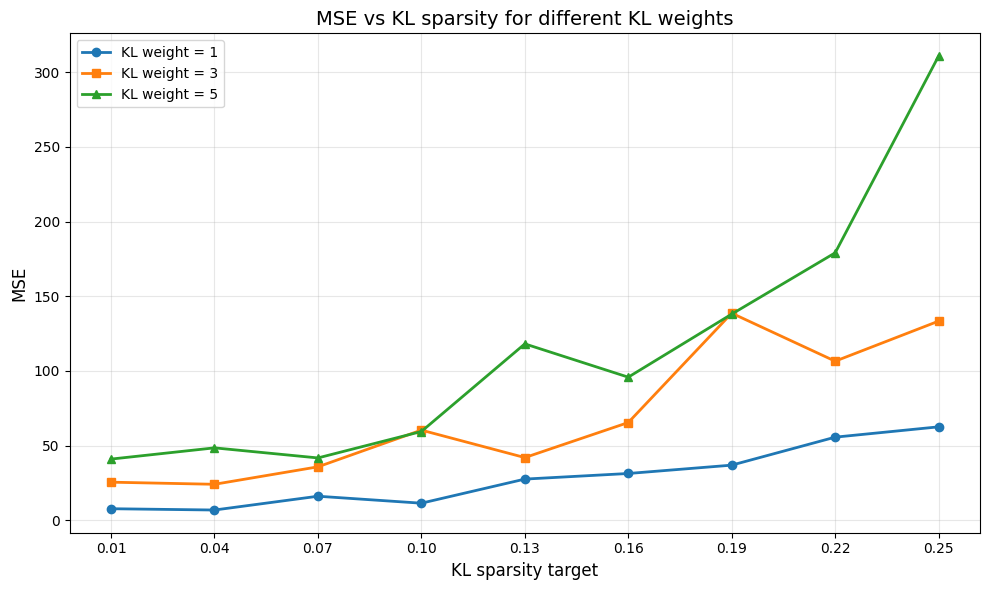

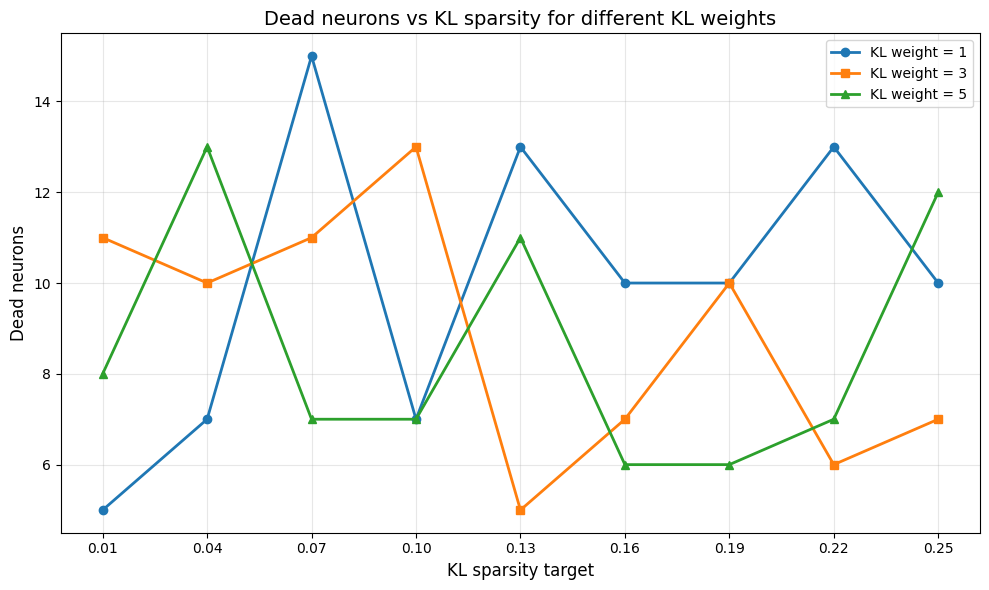


=== KL Weight Comparison Summary ===
Sparsity | MSE(w=1) | Dead(w=1) | MSE(w=3) | Dead(w=3) | MSE(w=5) | Dead(w=5)
----------------------------------------------------------------------
   0.01 |   7.7311 |        5 |  25.5080 |       11 |  40.9706 |        8
   0.04 |   6.8606 |        7 |  24.0939 |       10 |  48.4913 |       13
   0.07 |  16.0975 |       15 |  35.7883 |       11 |  41.7443 |        7
   0.10 |  11.4359 |        7 |  60.3700 |       13 |  59.4465 |        7
   0.13 |  27.5744 |       13 |  41.9829 |        5 | 118.1347 |       11
   0.16 |  31.3229 |       10 |  65.4583 |        7 |  95.8318 |        6
   0.19 |  36.9160 |       10 | 138.6769 |       10 | 138.0677 |        6
   0.22 |  55.6613 |       13 | 106.5381 |        6 | 179.1068 |        7
   0.25 |  62.5702 |       10 | 133.3698 |        7 | 310.8937 |       12


In [50]:
import numpy as np

x = np.array(sparsity_range)
y_mse = np.array(mse_kl_results)
y_dead = np.array(dead_neurons_kl_results)

# Plot MSE for all weights
plt.figure(figsize=(10,6))
colors = ['C0', 'C1', 'C2']
markers = ['o', 's', '^']
for i, w in enumerate(weights):
    plt.plot(x, y_mse[i], marker=markers[i], linestyle='-', color=colors[i], 
             label=f'KL weight = {w}', linewidth=2, markersize=6)

plt.xlabel('KL sparsity target', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('MSE vs KL sparsity for different KL weights', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.xticks(x)
plt.tight_layout()
plt.savefig('graphs/mse_vs_KL_all_weights.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot Dead neurons for all weights
plt.figure(figsize=(10,6))
for i, w in enumerate(weights):
    plt.plot(x, y_dead[i], marker=markers[i], linestyle='-', color=colors[i], 
             label=f'KL weight = {w}', linewidth=2, markersize=6)

plt.xlabel('KL sparsity target', fontsize=12)
plt.ylabel('Dead neurons', fontsize=12)
plt.title('Dead neurons vs KL sparsity for different KL weights', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.xticks(x)
plt.tight_layout()
plt.savefig('graphs/dead_vs_KL_all_weights.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary table
print("\n=== KL Weight Comparison Summary ===")
print("Sparsity", end="")
for w in weights:
    print(f" | MSE(w={w}) | Dead(w={w})", end="")
print()
print("-" * (10 + len(weights) * 20))

for j, s in enumerate(sparsity_range):
    print(f"{s:>7.2f}", end="")
    for i, w in enumerate(weights):
        print(f" | {y_mse[i][j]:>8.4f} | {y_dead[i][j]:>8d}", end="")
    print()


# KL Divergence vs TopK Comparison

In [ ]:
# Compare KL Divergence vs TopK methods
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define sparsity levels to test (roughly equivalent between methods)
sparsity_levels = [0.05, 0.10, 0.15, 0.20, 0.25]  # KL sparsity targets
k_values = [6, 13, 19, 26, 32]  # TopK values (roughly 5%, 10%, 15%, 20%, 25% of 128 hidden units)

# Storage for results
comparison_results = {
    'sparsity_levels': sparsity_levels,
    'kl_mse': [], 'kl_dead': [],
    'topk_mse': [], 'topk_dead': []
}

print("=== Training KL Divergence Models ===")
for s in sparsity_levels:
    print(f'\nTraining KL model with sparsity target {s:.2f}')
    model_kl = train_sparse_autoencoder(
        train_loader, 
        num_epochs=25,
        learning_rate=0.001,
        input_size=784,
        hidden_size=128, 
        modelType="SAE_KL", 
        dataset_type="mnist",
        sparsity_target=s,
        kl_weight=3.0
    )
    
    # Evaluate KL model
    dead_neurons = count_dead_neurons(model_kl, train_loader, dataset_type='mnist')
    mse = test_loss(model_kl, test_loader, dataset_type='mnist')
    
    comparison_results['kl_mse'].append(mse)
    comparison_results['kl_dead'].append(dead_neurons)
    
    print(f"KL Results - MSE: {mse:.4f}, Dead: {dead_neurons}")

print("\n=== Training TopK Models ===")
for k in k_values:
    print(f'\nTraining TopK model with k={k}')
    model_topk = train_sparse_autoencoder(
        train_loader, 
        num_epochs=25,
        learning_rate=0.001,
        input_size=784,
        hidden_size=128, 
        modelType="SAE", 
        dataset_type="mnist",
        k_top=k
    )
    
    # Evaluate TopK model
    dead_neurons = count_dead_neurons(model_topk, train_loader, dataset_type='mnist')
    mse = test_loss(model_topk, test_loader, dataset_type='mnist')
    
    comparison_results['topk_mse'].append(mse)
    comparison_results['topk_dead'].append(dead_neurons)
    
    print(f"TopK Results - MSE: {mse:.4f}, Dead: {dead_neurons}")

print("\n=== Training Complete! ===")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MSE comparison
x_labels = [f"{int(s*100)}%" for s in sparsity_levels]
axes[0].plot(x_labels, comparison_results['kl_mse'], 
            marker='o', linestyle='-', color='blue', label='KL Divergence')
axes[0].plot(x_labels, comparison_results['topk_mse'], 
            marker='s', linestyle='--', color='red', label='TopK')
axes[0].set_xlabel('Sparsity Level')
axes[0].set_ylabel('MSE')
axes[0].set_title('MSE: KL Divergence vs TopK')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Dead neurons comparison
axes[1].plot(x_labels, comparison_results['kl_dead'], 
            marker='o', linestyle='-', color='blue', label='KL Divergence')
axes[1].plot(x_labels, comparison_results['topk_dead'], 
            marker='s', linestyle='--', color='red', label='TopK')
axes[1].set_xlabel('Sparsity Level')
axes[1].set_ylabel('Dead Neurons')
axes[1].set_title('Dead Neurons: KL Divergence vs TopK')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('graphs/kl_vs_topk_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary table
print("\n=== Summary Comparison ===")
print("Sparsity | KL MSE  | TopK MSE | KL Dead | TopK Dead")
print("-" * 50)
for i, s in enumerate(sparsity_levels):
    print(f"{int(s*100):>7}% | {comparison_results['kl_mse'][i]:>6.4f} | "
          f"{comparison_results['topk_mse'][i]:>7.4f} | "
          f"{comparison_results['kl_dead'][i]:>6d} | {comparison_results['topk_dead'][i]:>8d}")

Using device: cuda
=== Training KL Divergence Models ===

Training KL model with sparsity target 0.05
Epoch [1/25], Loss: 93.1519
Epoch [2/25], Loss: 84.0747
Epoch [3/25], Loss: 62.4327
Epoch [4/25], Loss: 47.5445
Epoch [5/25], Loss: 38.4491
Epoch [6/25], Loss: 33.7234
Epoch [7/25], Loss: 31.0573
Epoch [8/25], Loss: 30.1266
Epoch [9/25], Loss: 29.7370
Epoch [10/25], Loss: 28.7690
Epoch [11/25], Loss: 28.4820
Epoch [12/25], Loss: 28.6390
Epoch [13/25], Loss: 28.8175
